In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Cropping1D, Dropout, Conv1D, MaxPool1D, UpSampling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop, Adam

# Load and preprocess data
def load_data(filename):
    df = pd.read_csv(filename)
    label_replacements = {
        'DDoS-ICMP_Flood': 'DDoS', 'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS',
        'DDoS-SYN_Flood': 'DDoS', 'DDoS-RSTFINFlood': 'DDoS', 'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
        'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DDoS-SlowLoris': 'DDoS',
        'DoS-UDP_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-SYN_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
        'Recon-HostDiscovery': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon', 'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon',
        'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai',
        'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing',
        'DictionaryBruteForce': 'BruteForce',
        'BrowserHijacking': 'Web-based', 'XSS': 'Web-based', 'Uploading_Attack': 'Web-based', 'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based',
        'BenignTraffic': 'BENIGN'
    }
    df['label'] = df['label'].replace(label_replacements)
    return df
dataset = []
for i in range(0, 5):
    df = load_data(f"/kaggle/input/cic-iot-2023/part-0000{i}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
    dataset.append(df)
dataset = pd.concat(dataset)

2024-05-21 15:52:24.430492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:52:24.430554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:52:24.432111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191264 entries, 0 to 227490
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1191264 non-null  float64
 1   Header_Length    1191264 non-null  float64
 2   Protocol Type    1191264 non-null  float64
 3   Duration         1191264 non-null  float64
 4   Rate             1191264 non-null  float64
 5   Srate            1191264 non-null  float64
 6   Drate            1191264 non-null  float64
 7   fin_flag_number  1191264 non-null  float64
 8   syn_flag_number  1191264 non-null  float64
 9   rst_flag_number  1191264 non-null  float64
 10  psh_flag_number  1191264 non-null  float64
 11  ack_flag_number  1191264 non-null  float64
 12  ece_flag_number  1191264 non-null  float64
 13  cwr_flag_number  1191264 non-null  float64
 14  ack_count        1191264 non-null  float64
 15  syn_count        1191264 non-null  float64
 16  fin_count        1191264

In [3]:
dataset.value_counts('label')

label
DDoS          867152
DoS           206502
Mirai          67193
BENIGN         27870
Spoofing       12499
Recon           9070
Web-based        616
BruteForce       362
Name: count, dtype: int64

In [4]:
label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])
dataset.value_counts('label')

label
2    867152
3    206502
4     67193
0     27870
6     12499
5      9070
7       616
1       362
Name: count, dtype: int64

In [5]:
# Compute correlation matrix
corr_matrix = dataset.corr()

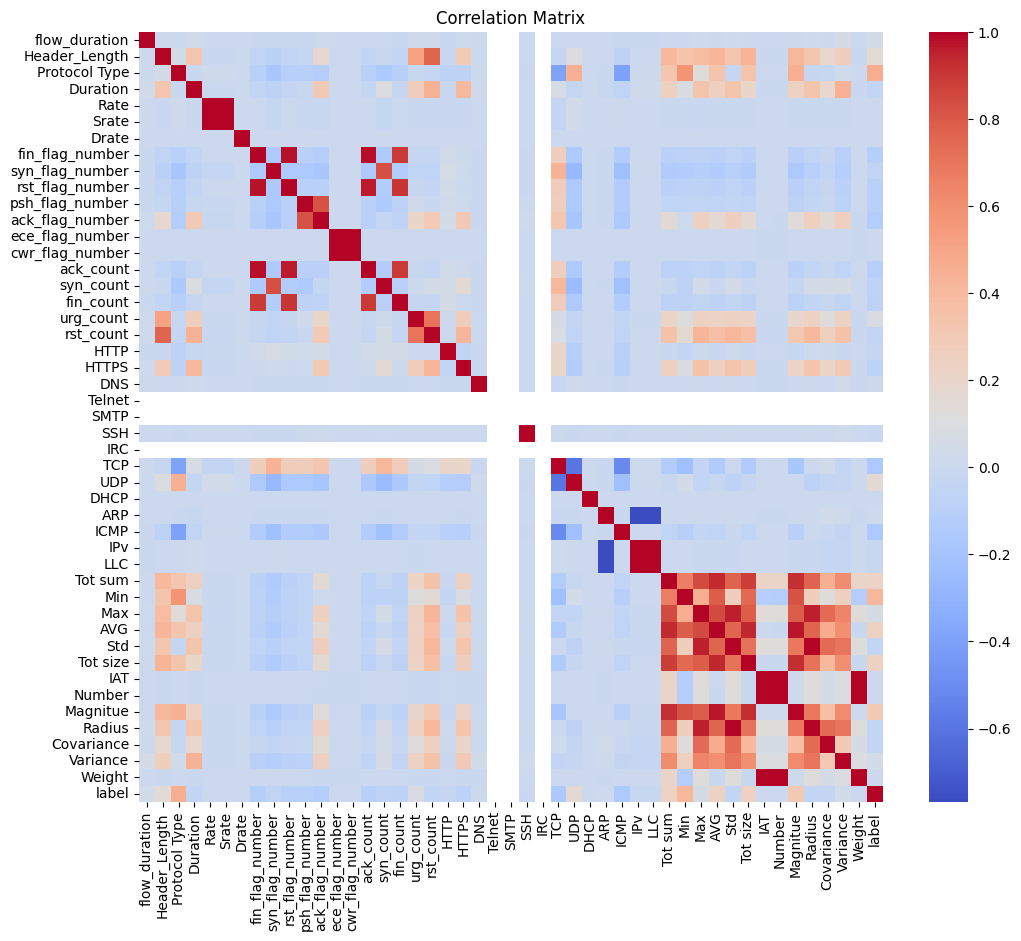

In [6]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

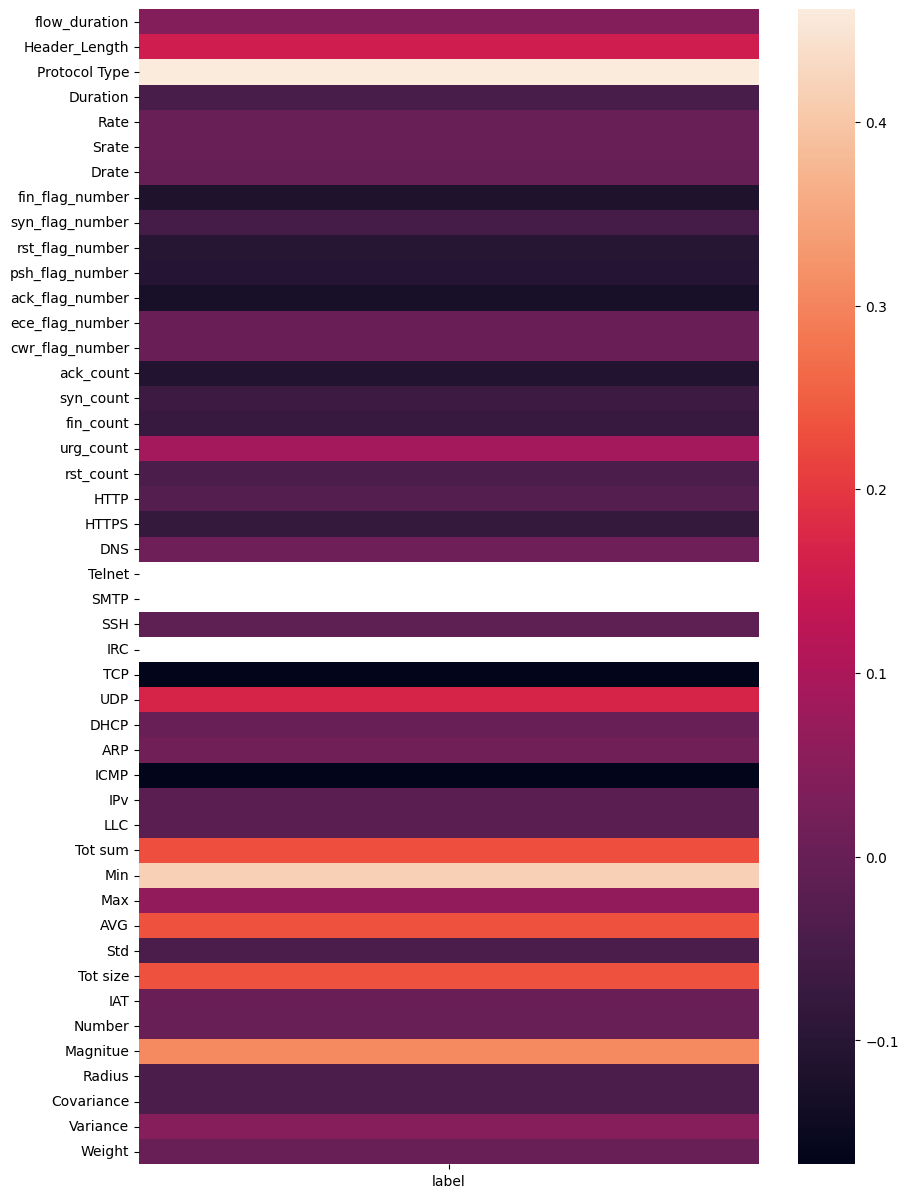

In [7]:
import seaborn as sns
plt.subplots(figsize=(10,15))
heat = sns.heatmap(corr_matrix.iloc[:46,46:])

In [8]:
X = dataset.drop(columns='label')

In [9]:
X.describe

<bound method NDFrame.describe of         flow_duration  Header_Length  Protocol Type  Duration          Rate  \
0            0.000000          54.00           6.00     64.00      0.329807   
1            0.000000          57.04           6.33     64.00      4.290556   
2            0.000000           0.00           1.00     64.00     33.396799   
3            0.328175       76175.00          17.00     64.00   4642.133010   
4            0.117320         101.73           6.11     65.91      6.202211   
...               ...            ...            ...       ...           ...   
227486       0.000000          54.31           6.11     64.00      0.000000   
227487       0.000000          54.00           6.00     64.00      5.984118   
227488      19.134826     1555059.10          17.00     64.00    128.064921   
227489       0.000000          54.00           6.00     64.00      3.007082   
227490       0.067734       15560.50          16.83     63.36  13184.134755   

               Sr

In [10]:
y = dataset['label']

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize the feature data
scaler = StandardScaler()
#scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(X)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(normalized_features, y, test_size=0.2, random_state=42)

# Reshape features for Conv1D input
X_train_encoder = np.expand_dims(X_train, axis=-1)
X_val_encoder = np.expand_dims(X_val, axis=-1)

In [13]:
test=[]
test = load_data("/kaggle/input/cic-iot-2023/part-00016-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")

In [14]:
X_test = scaler.fit_transform(test.drop(columns='label'))

In [15]:
test['label'] = label_encoder.fit_transform(test['label'])
y_test = test['label']
test.value_counts('label')

label
2    169276
3     40492
4     13322
0      5400
6      2473
5      1742
7       125
1        55
Name: count, dtype: int64

In [16]:
# Assuming X_train, X_val, X_test are already defined and preprocessed
X_train_expanded = X_train.reshape(-1, X_train.shape[1], 1)
X_val_expanded = X_val.reshape(-1, X_val.shape[1], 1)
X_test_expanded = X_test.reshape(-1, X_test.shape[1], 1)

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, MaxPool1D, UpSampling1D, Cropping1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError

def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv1D(128, 3, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPool1D(2, padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    encoded = MaxPool1D(2, padding='same')(x)

    # Decoder
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = UpSampling1D(2)(x)
    x = Cropping1D((1, 1))(x)
    decoded = Conv1D(input_shape[1], 3, activation='linear', padding='same')(x)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())
    return autoencoder

In [31]:
# Build and train the autoencoder model
autoencoder = build_autoencoder((X_train_expanded.shape[1], 1))
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 46, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 46, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 23, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 23, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 23, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 24, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 46, 1)          │           385 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 64,289 (251.13 KB)

 Trainable params: 63,457 (247.88 KB)

 Non-trainable params: 832 (3.25 KB)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch % 3 == 0 and epoch != 0:
        return lr * 0.9  # Reduce learning rate by 10%
    return lr

# Create callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [33]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_expanded, X_train_expanded,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(X_val_expanded, X_val_expanded),
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 63s 7ms/step - loss: 0.6938 - val_loss: 0.0859 - learning_rate: 1.0000e-04
Epoch 2/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.2172 - val_loss: 0.0851 - learning_rate: 1.0000e-04
Epoch 3/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.1938 - val_loss: 0.0997 - learning_rate: 1.0000e-04
Epoch 4/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.1531 - val_loss: 0.0743 - learning_rate: 9.0000e-05
Epoch 5/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.1782 - val_loss: 0.0835 - learning_rate: 9.0000e-05
Epoch 6/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.1428 - val_loss: 0.0859 - learning_rate: 9.0000e-05
Epoch 7/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.1332 - val_loss: 0.0674 - learning_rate: 8.1000e-05
Epoch 8/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.1099 - val_loss: 0.0807 - learning_rate: 8.1000e-05
Epoch 9/15
7446/7446 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0

In [34]:
# Evaluate the autoencoder on the test dataset
test_loss = autoencoder.evaluate(X_test_expanded, X_test_expanded)
print(f"Test Loss: {test_loss}")

7278/7278 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0639
Test Loss: 0.0657162293791771


In [35]:
# Predict on the test dataset
X_test_reconstructed = autoencoder.predict(X_test_expanded)
print(f"Test expanded:\n {X_test_expanded}")
print(f"Test reconstructed:\n {X_test_reconstructed}")

7278/7278 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Test expanded:
 [[[-1.56526293e-03]
  [-1.56724882e-01]
  [-9.91707173e-02]
  ...
  [-9.23631841e-02]
  [ 3.46627793e+00]
  [-4.90341813e+00]]

 [[-1.85538405e-02]
  [-1.66924730e-01]
  [-9.01829976e-01]
  ...
  [-1.01914273e-01]
  [-4.13624041e-01]
  [ 4.21100874e-03]]

 [[-1.51654845e-02]
  [ 1.03584605e+00]
  [ 8.57331566e-01]
  ...
  [ 9.99137912e-01]
  [ 3.68182804e+00]
  [ 4.21100874e-03]]

 ...

 [[-3.65617298e-03]
  [-1.66693491e-01]
  [-3.51116540e-01]
  ...
  [-1.01914018e-01]
  [-2.41183954e-01]
  [ 4.21100874e-03]]

 [[-1.85538405e-02]
  [-1.66924730e-01]
  [-9.01829976e-01]
  ...
  [-1.01914273e-01]
  [-4.13624041e-01]
  [ 4.21100874e-03]]

 [[-1.85538405e-02]
  [-1.66924730e-01]
  [ 4.22627084e+00]
  ...
  [-1.01914273e-01]
  [-4.13624041e-01]
  [ 4.21100874e-03]]]
Test reconstructed:
 [[[ 2.5839096e-01]
  [-1.0933371e-01]
  [-7.5412512e-02]
  ...
  [-3.3668976e-02]
  [ 2.6843605e+00]
  [-3.6361618e+00]]

 [[ 8.5823704e-03]
  [-

In [36]:
# Print a few original and reconstructed values for comparison
for i in range(5):  # Check first 5 samples
    original_value = X_test_expanded[i][0]
    reconstructed_value = X_test_reconstructed[i][0]
    print(f"Original: {original_value}, Reconstructed: {reconstructed_value}")

# Check the range of values
print(f"Range of original values: {X_test_expanded.min()} to {X_test_expanded.max()}")
print(f"Range of reconstructed values: {X_test_reconstructed.min()} to {X_test_reconstructed.max()}")

Original: [-0.00156526], Reconstructed: [0.25839096]
Original: [-0.01855384], Reconstructed: [0.00858237]
Original: [-0.01516548], Reconstructed: [0.00599099]
Original: [-0.0184968], Reconstructed: [-0.03393441]
Original: [-0.01855384], Reconstructed: [-0.05995922]
Range of original values: -82.75601986278348 to 482.5805632223493
Range of reconstructed values: -152.3629150390625 to 555.2155151367188


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Reshape reconstructed values to match the original expanded shape
X_test_reconstructed = X_test_reconstructed.reshape(X_test_expanded.shape)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(X_test_expanded.flatten(), X_test_reconstructed.flatten())

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(X_test_expanded.flatten(), X_test_reconstructed.flatten())

# Compute R^2 Score
r2 = r2_score(X_test_expanded.flatten(), X_test_reconstructed.flatten())

# Compute Pearson Correlation Coefficient
correlation_matrix = np.corrcoef(X_test_expanded.flatten(), X_test_reconstructed.flatten())
correlation_coefficient = correlation_matrix[0, 1]

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")
print(f"Pearson Correlation Coefficient: {correlation_coefficient}")

Mean Absolute Error (MAE): 0.08648939499436872
Mean Squared Error (MSE): 0.06571622596527095
R^2 Score: 0.9262696001365252
Pearson Correlation Coefficient: 0.9632793519090252


In [39]:
#autoencoder.save("autoencoder_with_StandardScaler_linear_MeanSquaredError.keras")